In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from SinglePhotonIO import getChannels
from cont_trigger import rand_sections_wrapper, calc_psd, OptimumFilt
from cut_utils import autocuts
from time import time

% matplotlib inline

In [2]:
fpath = sorted(glob("/nerodata/HVStudy/2018/Run164/trace_data/180612_1554/*.mat"))
# fpath = sorted(glob("/nerodata/HVStudy/2018/Run164/trace_data/180703_0825/*.mat"))

f = []
for ff in fpath:
    f.append(int(ff[65:67].replace(".","")))
    
filepath = [x for _,x in sorted(zip(f,fpath))]

In [3]:
start = time()

n, l = 2000, 125000
t, res = rand_sections_wrapper(filepath, n, l)
print(time()-start)


929.2312598228455


In [4]:
pt = res.sum(axis=1)
cut = autocuts(pt, fs=1.25e6)
f, psd = calc_psd(pt[cut], fs=1.25e6, folded_over=False)

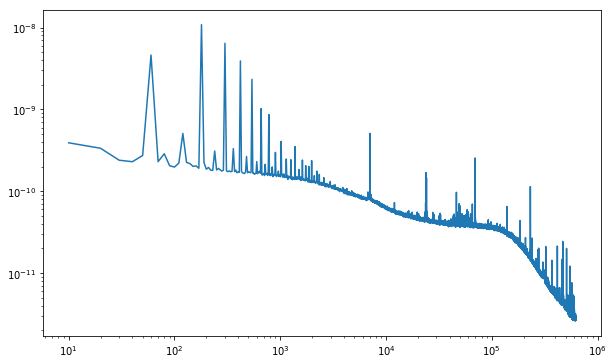

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(f[f>0],np.sqrt(2*psd[f>0]))
ax.set_yscale("log")
ax.set_xscale("log")

In [6]:
fs = 1.25e6
tracelength = 125000
# Dummy pulse template
nbin = len(psd)
ind_trigger = round(nbin/2)
timess = 1.0/fs *(np.arange(1,nbin+1)-ind_trigger)
lgc_b0= timess < 0.0

# pulse shape
tau_risepulse= 20.0e-6
tau_fallpulse= 80.0e-6
testTemplate = (1.0-np.exp(-timess/tau_risepulse))*np.exp(-timess/tau_fallpulse)
testTemplate[lgc_b0]=0.0
testTemplate = testTemplate/max(testTemplate)

In [7]:
triglen = 64
ttltime = 8e-6 # length of ttl pulse in seconds
ttllen = int(ttltime*fs)
ind_trigger = round(triglen/2)

trigtemplate = np.zeros(triglen)
trigtemplate[ind_trigger:ind_trigger+ttllen] = 1

In [8]:
start = time()

pulses = getChannels(filepath[0])
fs = pulses["prop"]["sample_rate"][0][0][0][0]
traces = np.stack((pulses["A"], pulses["B"]), axis=1)/1024
trig = pulses["T"]*1e6/1024
times = pulses["time"]

print(time()-start)

13.232543706893921


In [9]:
[float(val) for val in pulses["prop"]["agilent"][0][0][0][4:-2].split(',')]
pulses["prop"]["agilent"][0][0][0][4:-2]

ValueError: could not convert string to float: 

In [10]:
if len(trig)==0:
    OF = OptimumFilt(fs, testTemplate, psd, tracelength)
    OF.filtertraces(traces, times)
    OF.eventtrigger(4, positivepulses=False)
else:
    OF = OptimumFilt(fs, testTemplate, psd, tracelength, trigtemplate=trigtemplate)
    OF.filtertraces(traces, times, trig = trig)
    OF.eventtrigger(4, trigthresh=0.8)

In [14]:
27*OF.resolution

2.636557777481901e-07

(2.5e-06, 3.5e-06)

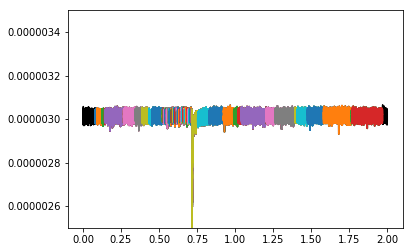

In [132]:
tarr = np.arange(0,len(traces[0].sum(axis=0)))/fs
plt.plot(tarr, traces[0].sum(axis=0), color="k")

n = 104
for t, tt in zip(OF.pulsetimes[:n], OF.evttraces[:n].sum(axis=1)):
    
    relt = t-times[0]
    tarr = np.arange(0,len(tt))/fs + relt - (len(tt)//2)/fs
    plt.plot(tarr, tt)

# plt.xlim([0.05,0.15])
plt.ylim([2.5e-6,3.5e-6])